In [1]:
import os
import sys
import docopt
import IPython
import ipywidgets as widgets
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

In [2]:
from IPython.display import HTML, display
from ipywidgets import interact, interactive

# from plotting_functions import *
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.linear_model import LogisticRegression

# from utils import *

In [3]:
import pickle

In [4]:
df = pd.read_csv(
    "../../data/raw/abalone.data",
    names=[
        "Sex",
        "Length",
        "Diameter",
        "Height",
        "Whole weight",
        "Shucked weight",
        "Viscera weight",
        "Shell weight",
        "Rings",
    ],
    header=0,
)

# Add a classification target columns. If rings > 11, then classified as old
df["Is old"] = np.where(df["Rings"] > 11, "old", "young")
df.head()
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
X_train = train_df.drop(columns=["Is old"])
X_test = test_df.drop(columns=["Is old"])
y_train = train_df["Is old"]
y_test = test_df["Is old"]
y_test = y_test.map({"young": 1, "old": 0}).astype(int)
y_train = y_train.map({"young": 1, "old": 0}).astype(int)

In [5]:
y_test

2812    1
1344    1
533     1
866     1
3939    0
       ..
1886    1
3724    1
1203    0
3889    0
2597    1
Name: Is old, Length: 836, dtype: int32

In [6]:
# create column transformer for analysis pipeline

categorical_feature = ["Sex"]
numerical_features = [
    "Length",
    "Diameter",
    "Height",
    "Whole weight",
    "Shucked weight",
    "Viscera weight",
    "Shell weight",
]
target = "Is old"
drop_feature = ["Rings"]

preprocessor = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_feature),
    ("drop", drop_feature),
)

In [7]:
# fit the model by using random search CV

lr = LogisticRegression(max_iter=2000)
pipe = make_pipeline(preprocessor, lr)
param_grid = {"logisticregression__C": 10.0 ** np.arange(-3, 6)}

random_search = RandomizedSearchCV(
    pipe, param_distributions=param_grid, n_jobs=-1, n_iter=10, cv=5, random_state=123
)
random_search.fit(pd.DataFrame(X_train), y_train)

C:\Users\Maoli\miniconda3\envs\571\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['Length',
                                                                                'Diameter',
                                                                                'Height',
                                                                                'Whole '
                                                                                'weight',
                                                                                'Shucked '
                                                                                'weight',
                                                                                'V

In [8]:
# view the training results in a data frame

train_results = (
    pd.DataFrame(random_search.cv_results_)[
        [
            "mean_test_score",
            "param_logisticregression__C",
            "mean_fit_time",
            "rank_test_score",
        ]
    ]
    .set_index("rank_test_score")
    .sort_index()
)
train_results

,mean_test_score,param_logisticregression__C,mean_fit_time
rank_test_score,,,
1,0.826403,100.0,0.035000
1,0.826403,1000.0,0.035802
1,0.826403,10000.0,0.034600
1,0.826403,100000.0,0.028197
5,0.826104,10.0,0.044797
6,0.822811,1.0,0.036799
7,0.820115,0.1,0.033999
8,0.798865,0.01,0.026000
9,0.775518,0.001,0.025201


In [9]:
random_search.cv_results_

{'mean_fit_time': array([0.02520132, 0.02600031, 0.03399911, 0.03679924, 0.04479666,
        0.03499999, 0.03580189, 0.0346004 , 0.02819681]),
 'std_fit_time': array([0.00256093, 0.00209856, 0.00753827, 0.0028561 , 0.00299379,
        0.00802471, 0.00847307, 0.00241646, 0.00285644]),
 'mean_score_time': array([0.0058001 , 0.0078002 , 0.00660033, 0.00599794, 0.00780091,
        0.00679955, 0.00599856, 0.00539851, 0.004     ]),
 'std_score_time': array([0.00097881, 0.00222761, 0.00174244, 0.00063203, 0.00271298,
        0.0024011 , 0.00063167, 0.00048842, 0.00089394]),
 'param_logisticregression__C': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0,
                    100000.0],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'logisticregression__C': 0.001},
  {'logisticregression__C': 0.01},
  {'logisticregression__C': 0.1},
  {'logisticregressi

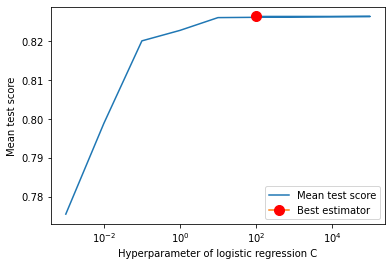

In [10]:
# train_results.plot(kind="line", y="mean_test_score")
from matplotlib import pyplot

train_results.plot(x="param_logisticregression__C", y="mean_test_score")
plt.plot(100, 0.826403, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
plt.xlabel("Hyperparameter of logistic regression C")
plt.ylabel("Mean test score")
plt.legend(["Mean test score", "Best estimator"])
plt.xscale("log")
plt.savefig("../../models/cv_result.png")

In [11]:
# pick the final model and predict test data

best_c = train_results.iloc[1, 0]

pipe_best = make_pipeline(preprocessor, LogisticRegression(C=best_c, max_iter=2000))
pipe_best.fit(X_train, y_train)

pipe_best.score(X_test, y_test)

0.8433014354066986

In [12]:
random_search.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Length', 'Diameter',
                                                   'Height', 'Whole weight',
                                                   'Shucked weight',
                                                   'Viscera weight',
                                                   'Shell weight']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Sex']),
                                                 ('drop', 'drop', ['Rings'])])),
                ('logisticregression',
                 LogisticRegression(C=100.0, max_iter=

In [30]:
feature_names = np.array(pipe_best[:-1].get_feature_names_out())
name = []

for n in feature_names.tolist():
    name.append(n.split('__')[1])

coeffs = pipe_best.named_steps["logisticregression"].coef_.flatten()
coeff_df = pd.DataFrame(coeffs, index=name, columns=["Coefficient"])
coeff_df_sorted = coeff_df.sort_values(by="Coefficient", ascending=False)
coeff_df_sorted

,Coefficient
Shucked weight,3.405154
Sex_I,0.576915
Viscera weight,0.521920
Length,0.471001
Height,-0.260923
Sex_M,-0.287910
Sex_F,-0.291111
Diameter,-0.483618
Shell weight,-1.438815
Whole weight,-2.920781


In [29]:
name = []

for n in feature_names.tolist():
    name.append(n.split('__')[1])
name

['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Shucked weight',
 'Viscera weight',
 'Shell weight',
 'Sex_F',
 'Sex_I',
 'Sex_M']

In [14]:
pipe_best.classes_

array([0, 1])

In [15]:
from mglearn.plot_2d_separator import (plot_2d_separator, plot_2d_classification,
                                plot_2d_scores)
from mglearn.plot_helpers import cm2 as cm, discrete_scatter

def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.
    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.
    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.
    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = [cm(1) if c < 0 else cm(0)
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(0, 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")

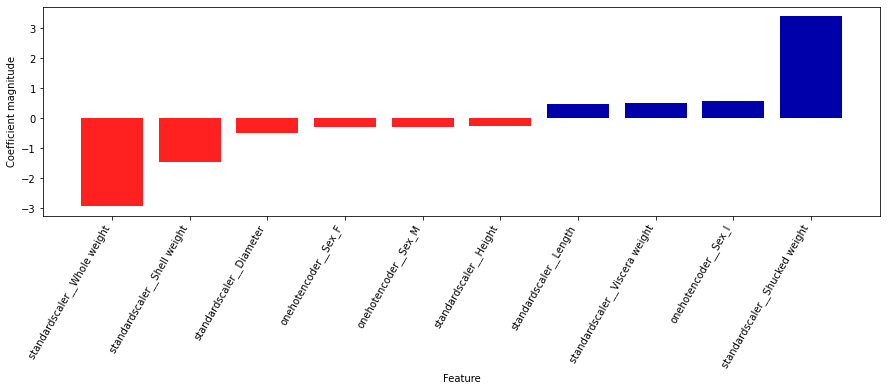

In [16]:
visualize_coefficients(coeffs, feature_names, n_top_features=5)
plt.savefig("../../models/coeff.png", bbox_inches = 'tight')

In [17]:
# export tables

import dataframe_image as dfi

dfi.export(train_results, "../../models/train_results.png")
dfi.export(coeff_df_sorted, "../../models/coeff_sorted.png")

In [18]:
from sklearn.metrics import get_scorer
from sklearn.metrics import make_scorer

scoring_metrics = [
    "accuracy",
    "f1",
    "recall",
    "precision",
    "roc_auc",
    "average_precision",
]
rdf = pd.DataFrame(scoring_metrics, columns=["Metrics"])

r = []
for m in scoring_metrics:
    r.append(get_scorer(m)(pipe_best, X_test, y_test))
rdf["Test Result"] = r
rdf.set_index("Metrics")

rdf

,Metrics,Test Result
0,accuracy,0.843301
1,f1,0.903321
2,recall,0.954758
3,precision,0.857143
4,roc_auc,0.854098
5,average_precision,0.945271
